# Model-3

In [1]:
import tensorflow as tf
import numpy as np
from dataset import Dataset, load_datasets
from config import get_dataset_path
from layers import *
from networks import *
from model import Model
from dbase import build_dbase
from evaluation import print_accuracy, plot_search_results

In [30]:
tr_data_path  = get_dataset_path("train/5557_300_128_128_1_uint8_aug2.npy")
va_data_path  = get_dataset_path("valid/550_300_128_128_1_uint8_aug2.npy")
model_path    = "models/003-v0/"

## Dataset

In [3]:
%%time
tr_dataset, va_dataset = load_datasets(tr_data_path, va_data_path)
print('-'*50)

/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/5557_300_128_128_1_uint8_aug2.npy:
 [5557, 300, 128, 128, 1] uint8
/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8_aug2.npy:
 [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 516 ms, sys: 37.9 s, total: 38.4 s
Wall time: 1min 23s


## Build 

In [4]:
%%time
out_dims       = 150
margin         = .5
network        = simple_conv

# v1: d=300 m=1 s=15k  lr=1e-6 tr_acc=87.3
# v2: d=300 m=3 s=15k  lr=1e-4 tr_acc=93.3
# v3: d=300 m=5 s=30k  lr=1e-4 tr_acc=97.3
# v4: d=100 m=5 s=175k lr=1e-4 tr_acc=98.0 va_acc=99.5
# v5: d=150 m=5 s=60k  lr=1e-4 tr_acc=97.7 va_acc=99.5

acc_batch_size = 300
image_shape    = list(tr_dataset.data.shape[-3:])
model          = Model(image_shape, out_dims, acc_batch_size)
model.build(network)

CPU times: user 4.45 s, sys: 72 ms, total: 4.52 s
Wall time: 4.77 s


## Train

In [31]:
%%time
model.train(
    step_num   = 60000, 
    batch_size = 64,
    lr         = 1e-4, 
    log_every  = 100,
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    log_scale  = True)

model.save(model_path)
print('-'*50)

--------------------------------------------------
CPU times: user 4.8 s, sys: 160 ms, total: 4.96 s
Wall time: 4.89 s


## Database

In [59]:
%%time
ethalons  = tr_dataset.get_ethalons()  # tr_dataset va_dataset
augmented = va_dataset.get_ethalons() # get_augmented() get_ethalons()

dbase     = build_dbase(model, ethalons, augmented)
print('-'*50)

Ethalons : [5557, 128, 128, 1] float32
Augmented: [550, 128, 128, 1] float32
Database : [5557, 150] float64
--------------------------------------------------
CPU times: user 1.22 s, sys: 2.47 s, total: 3.68 s
Wall time: 3.5 s


## Accuracy

In [60]:
%%time
print_accuracy(dbase, augmented, 5)

Database   : [5557, 150]
Request    : [550, 128, 128, 1]
Performance: 498 img/sec
--------------------------------------------------
Accuracy@1: 0.0%
Accuracy@2: 0.0%
Accuracy@3: 0.0%
Accuracy@4: 0.2%
Accuracy@5: 0.2%
--------------------------------------------------
CPU times: user 1.13 s, sys: 12 ms, total: 1.14 s
Wall time: 1.12 s


## Search

Database   : [5557, 150]
Request    : [550, 128, 128, 1]

Min distance: 0.00
Max distance: 0.86
Ave distance: 0.61


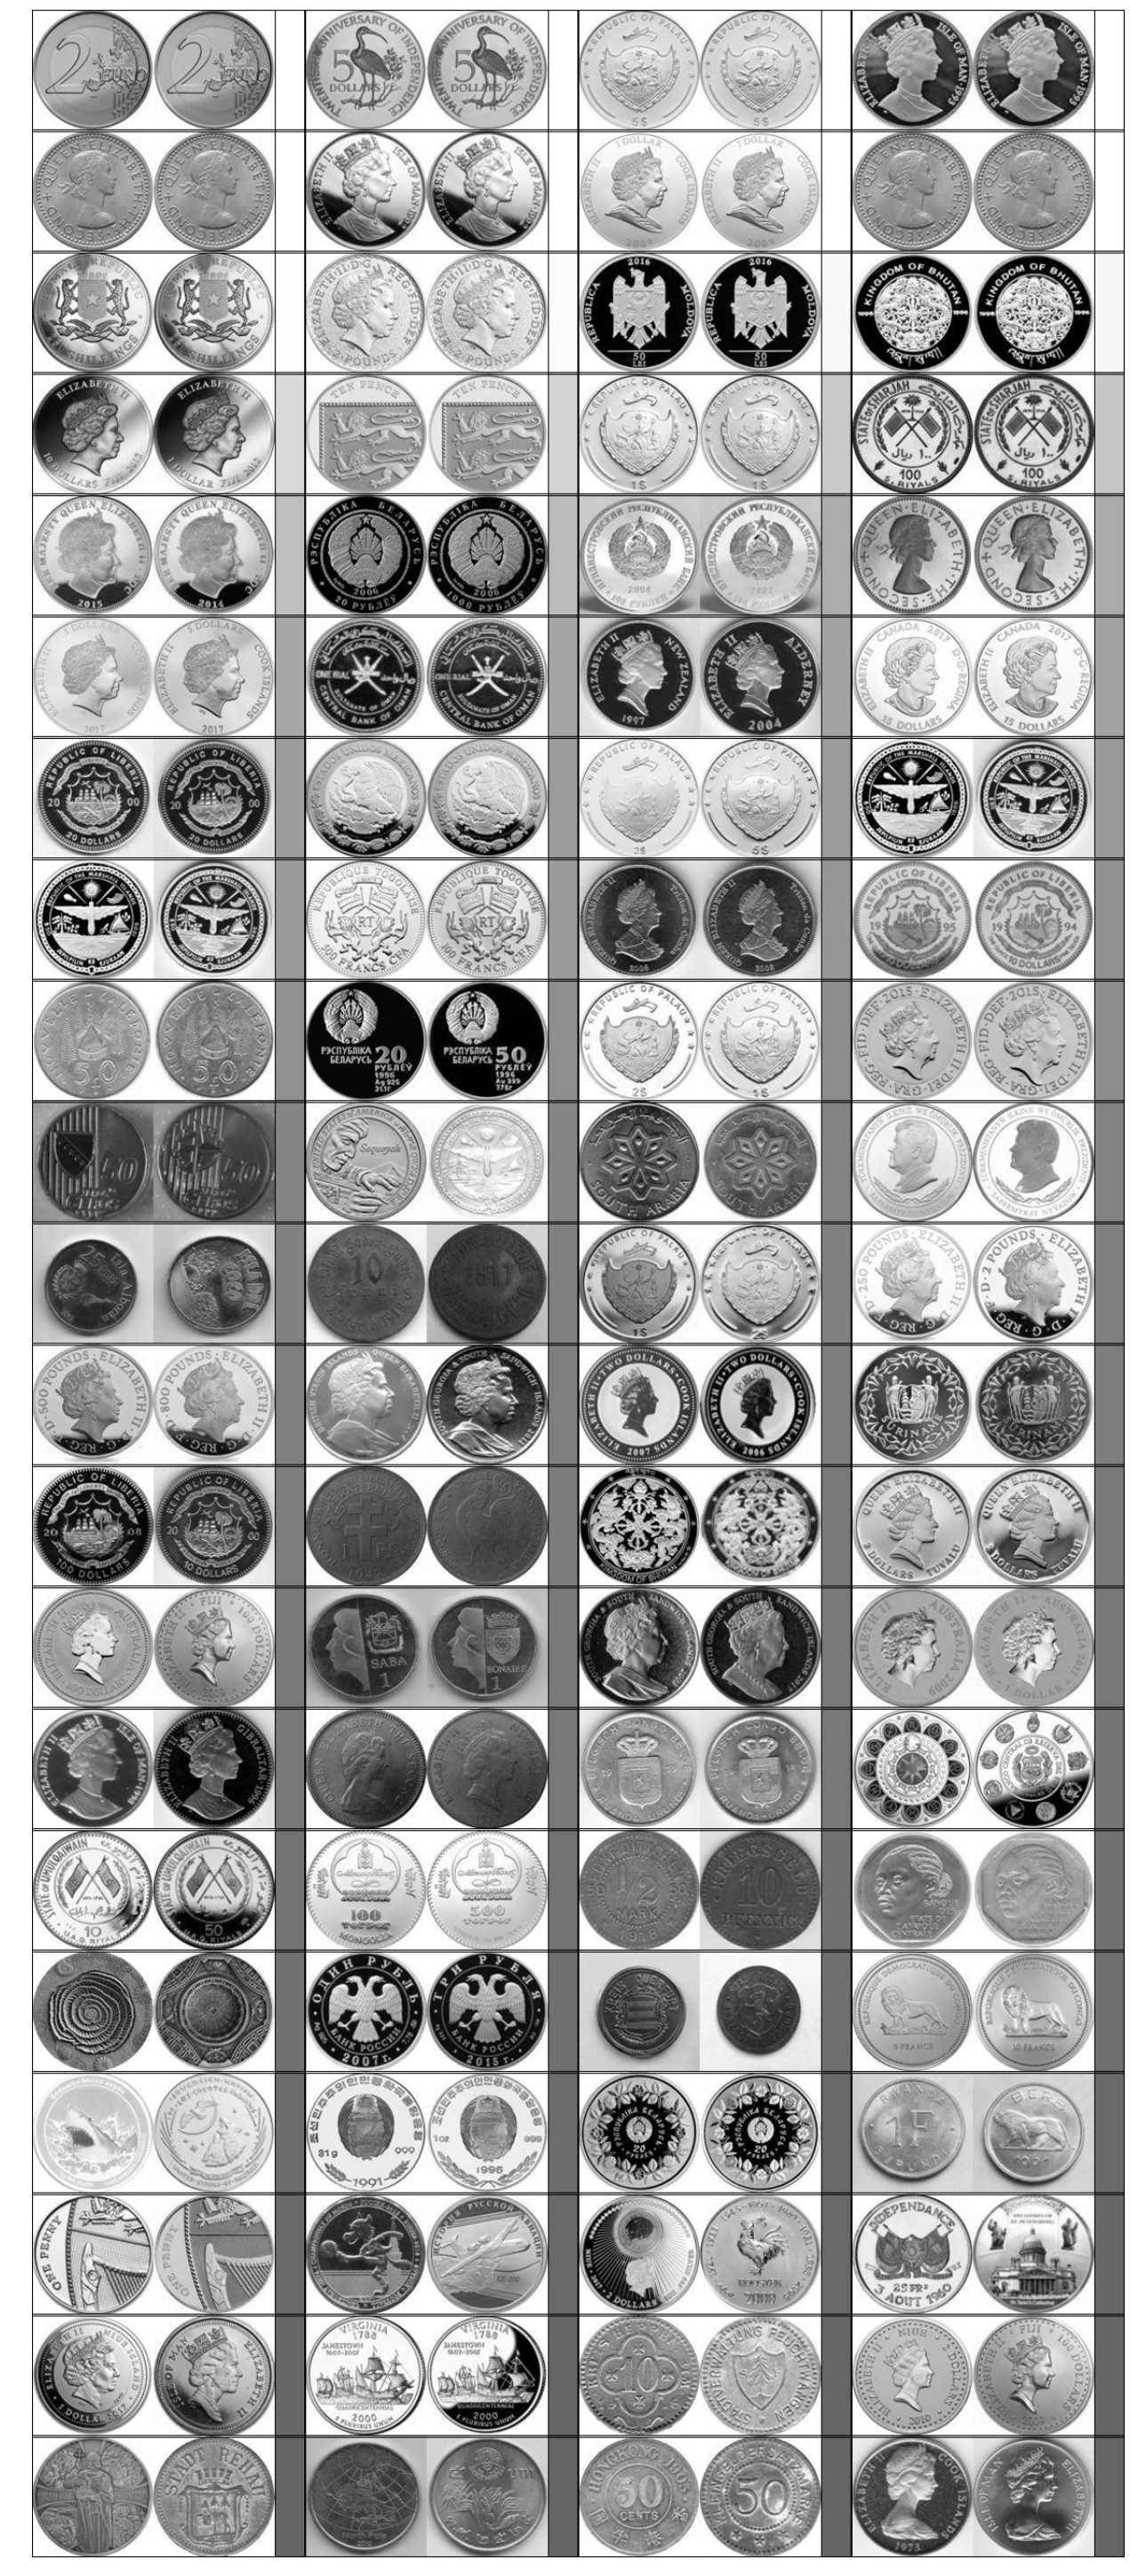

CPU times: user 5.22 s, sys: 1.48 s, total: 6.7 s
Wall time: 6.46 s


In [61]:
%%time
plot_search_results(dbase, augmented, num=550, cols=4, k=0, sort='asc', plot_limit=84)
#plot_search_results(dbase, augmented, num=550, cols=4, k=0, sort='desc', plot_limit=42)

## Restore

In [6]:
%time
model.restore(model_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs
INFO:tensorflow:Restoring parameters from models/003-v5/
